<a href="https://colab.research.google.com/github/suchig/Hotel-Reviews/blob/master/Hotel_Review_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from scipy.sparse import hstack, csr_matrix

#!pip install   xgboost
import xgboost as xgb
from xgboost import XGBRegressor

import nltk
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

#!pip install hyperopt
from hyperopt import fmin, tpe, STATUS_OK, Trials, hp;

---
# Initialization of data
Read the Hotel reviews csv file and examine its structure and information


In [0]:
hotels = pd.read_csv("Hotel_Reviews.csv")
print(hotels.shape)
print(hotels.info())

(515738, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
Hotel_Address                                 515738 non-null object
Additional_Number_of_Scoring                  515738 non-null int64
Review_Date                                   515738 non-null object
Average_Score                                 515738 non-null float64
Hotel_Name                                    515738 non-null object
Reviewer_Nationality                          515738 non-null object
Negative_Review                               515738 non-null object
Review_Total_Negative_Word_Counts             515738 non-null int64
Total_Number_of_Reviews                       515738 non-null int64
Positive_Review                               515738 non-null object
Review_Total_Positive_Word_Counts             515738 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515738 non-null int64
Reviewer_Score                                515738

Note above that several features are String/Object. We will have to convert this to numeric datatypes. 
1. Address, we know that Country is the most important aspect in the same. So we strip Off Country, categorize it as numeric. (We will remove Address later)
2. Convert Review_Date to numeric
3. Categorize Reviewer_Nationality to numeric
4. Convert Days_since_review to numeric

In [0]:
split_address = hotels['Hotel_Address'].str.split()
items = [item[-1] for item in split_address]

hotels["Country"], country_unique = pd.factorize(items)

hotels["Review_Date"] = hotels["Review_Date"].str.replace('/','')
hotels["Review_Date"] = hotels["Review_Date"].astype(int)

hotels["Reviewer_Nationality"], reviewer_nationality_unique = hotels['Reviewer_Nationality'].factorize()

split_days = hotels['days_since_review'].str.split()
items = [int(item[0]) for item in split_days]
hotels['days_since_review']=items

In [0]:
tag_values=hotels['Tags'].map(lambda val: re.sub('[\[\]\']','',val)) 
tag_values = tag_values.str.split(",",expand=True)

In [0]:
tag_values[0].value_counts()

 Leisure trip                   416672
 Business trip                   82748
 Couple                           5808
 Solo traveler                    4291
 Family with young children       2227
 Group                            1600
 With a pet                       1405
 Family with older children        931
 Travelers with friends             56
Name: 0, dtype: int64

In [0]:
tag_values[(tag_values[1].str.find("room")==-1) & 
           (tag_values[1].str.find("Room")==-1) &
          (tag_values[1].str.find("Studio")==-1) &
          (tag_values[1].str.find("Deluxe")==-1) &
          (tag_values[1].str.find("Double")==-1) &
          (tag_values[1].str.find("Suite")==-1)][1].value_counts()

  Couple                                              245788
  Solo traveler                                       104077
  Group                                                63663
  Family with young children                           58582
  Family with older children                           25331
  Travelers with friends                                2087
  Leisure trip                                          1106
  Business trip                                          191
  Standard                                                29
  Superior Shard King                                     22
  Duplex                                                   7
  Submitted from a mobile device                           6
  Dalston King                                             6
  Superior                                                 5
  Apartment                                                5
  Classique Square                                         4
  Standard Apartment    

In [0]:
tag_values[(tag_values[2].str.find("room")==-1) & 
           (tag_values[2].str.find("Room")==-1) &
          (tag_values[2].str.find("Studio")==-1) &
          (tag_values[2].str.find("Deluxe")==-1) &
          (tag_values[2].str.find("Double")==-1) &
          (tag_values[2].str.find("Suite")==-1) &
          (tag_values[2].str.find("Apartment")==-1) &
          (tag_values[2].str.find("King")==-1) &
          (tag_values[2].str.find("Queen")==-1) &
          (tag_values[2].str.find("Stayed")==-1)][2].value_counts()

  Standard                                     1200
  Couple                                        698
  Superior                                      265
  Family with young children                    206
  Solo traveler                                 177
  Group                                         129
  Maisonette                                    107
  Submitted from a mobile device                 99
  Luxury Four Poster                             89
  Family with older children                     87
  Romantic Special Offer                         49
  Loft                                           48
  Special Offer Princess Relax                   41
  Duplex                                         35
  Special Offer Only For Cruise Passengers       28
  Classique Square                               23
  Classic Designer                               21
  Classic Twin View                              19
  Atrium                                         16
  Superior D

In [0]:
tag_values[(tag_values[3].str.find("room")==-1) & 
           (tag_values[3].str.find("Room")==-1) &
          (tag_values[3].str.find("Studio")==-1) &
          (tag_values[3].str.find("Deluxe")==-1) &
          (tag_values[3].str.find("Double")==-1) &
          (tag_values[3].str.find("Suite")==-1) &
          (tag_values[3].str.find("Apartment")==-1) &
          (tag_values[3].str.find("King")==-1) &
          (tag_values[3].str.find("Queen")==-1) &
          (tag_values[3].str.find("Stayed")==-1)][3].value_counts()

  Submitted from a mobile device     9497
  Standard                              2
Name: 3, dtype: int64

In [0]:
tag_values[(tag_values[4].str.find("room")==-1) & 
           (tag_values[4].str.find("Room")==-1) &
          (tag_values[4].str.find("Studio")==-1) &
          (tag_values[4].str.find("Deluxe")==-1) &
          (tag_values[4].str.find("Double")==-1) &
          (tag_values[4].str.find("Suite")==-1) &
          (tag_values[4].str.find("Apartment")==-1) &
          (tag_values[4].str.find("King")==-1) &
          (tag_values[4].str.find("Queen")==-1) &
          (tag_values[4].str.find("Stayed")==-1)][4].value_counts()

  Submitted from a mobile device     297283
Name: 4, dtype: int64

In [0]:
hotels["Trip"] = 0

hotels.loc[hotels['Tags'].str.find('Leisure')!=-1,["Trip"]]=1
hotels.loc[hotels['Tags'].str.find('Business')!=-1,["Trip"]]=2

hotels['Group_Type'] = 0
hotels.loc[hotels['Tags'].str.find('Couple')!=-1,["Group_Type"]]=1
hotels.loc[hotels['Tags'].str.find('Family with older children')!=-1,["Group_Type"]]=2
hotels.loc[hotels['Tags'].str.find('Family with young children')!=-1,["Group_Type"]]=3
hotels.loc[hotels['Tags'].str.find('Group')!=-1,["Group_Type"]]=4
hotels.loc[hotels['Tags'].str.find('Solo traveler')!=-1,["Group_Type"]]=5
hotels.loc[hotels['Tags'].str.find('Travelers with friends')!=-1,["Group_Type"]]=6
hotels.loc[hotels['Tags'].str.find('With a pet')!=-1,["Group_Type"]]=7

hotels['Mobile'] = 0
hotels.loc[hotels['Tags'].str.find('Submitted from a mobile device')!=-1,["Mobile"]]=1

hotels["Stayed"]=0
for i in range(1,21):
  hotels.loc[hotels['Tags'].str.find('Stayed '+str(i)+' night')!=-1,["Stayed"]]=i

In [0]:
hotels[hotels['Negative_Review']=='No Negative']['Negative_Review']='NoNegative'
hotels[hotels['Positive_Review']=='No Positive']['Positive_Review']='NoPositive'

hotels[hotels["lat"].isnull()]["lat"]=0
hotels[hotels["lng"].isnull()]["lng"]=0

---
# Classification of reviews

This section deals with creating a classification model to train and infer positive_reviews and negative reviews . To do this structure of data has to be modified from

```
Row 1 -> Feature 1, ....Positive_Review 1, Negative Review 1,....
Row 2 -> Feature 2, ....Positive_Review 2, Negative Review 2,....
Row 3 -> Feature 3, ....Positive_Review 3, Negative Review 3,....
....
```

to the below structure
```
Row 1 -> Positive_Review 1, Rating Positive
Row 2 -> Positive_Review 2, Rating Positive
Row 3 -> Positive_Review 3, Rating Positive
Row 4 -> Negative Review 1, Rating Negative
Row 5 -> Negative Review 2, Rating Negative
Row 6 -> Negative Review 3, Rating Negative
....
```

In [0]:
neg_reviews = pd.DataFrame(hotels['Negative_Review'])
neg_reviews.rename(columns={"Negative_Review": "review"},inplace=True)
neg_reviews['rating']=0

pos_reviews = pd.DataFrame(hotels['Positive_Review'])
pos_reviews.rename(columns={"Positive_Review": "review"},inplace=True)
pos_reviews['rating']=1

reviews=pd.concat([pos_reviews,neg_reviews])

Split as test and train

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    reviews['review'], reviews['rating'], test_size=0.3, random_state=27)

In order to classify, positive and negative reviews have to be cleaned, segmented and lemmatized. After the same, CountVectorizer and TFIDTransformer will convert the reviews into tfid values.

In [0]:
lemmatizer = WordNetLemmatizer()
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

#method to split sentences to lemmatized words
def tokenize(text):
  
  # Remove punctuations
  text = text.lower().translate(remove_punct_dict)

  # Remove numeric entries
  text = re.sub("\d+", " ", text)
  
  #tokenize the sentence to words
  tokens = nltk.word_tokenize(text)
  
  #lemmatize the tokens
  tokens = [lemmatizer.lemmatize(token) for token in tokens]
  
  #remove below custom words since they are typing issues
  #remove any single letter tokens
  custom_stopWords=['wa'] 
  tokens = [t for t in tokens if ((t not in custom_stopWords) and (len(t)>1))]
  
  return tokens

In [0]:
nltk.download('punkt')
nltk.download('wordnet')
count_vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
tfid_transformer = TfidfTransformer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


X_train values are converted to Count Vector values using Count vector's fit_transform.
Count Vector values are converted to TFID values using TFI Transformer's fit_transformer.
These are fed as training X values to a classifier model, in this case, NaiveBayes Classifier (MultinomialNB)

In [0]:
count_X_train = count_vectorizer.fit_transform(X_train.values.astype(str).ravel())
tfid_X_train = tfid_transformer.fit_transform(count_X_train)
classifier = MultinomialNB()
classifier_train = classifier.fit(tfid_X_train,y_train)

Now with the trained model, y values are predicted for x and accuracy is calculated. It comes to about 88%. 

In [0]:
count_X_test = count_vectorizer.transform(X_test.values.astype(str).ravel())
tfid_X_test = tfid_transformer.transform(count_X_test)
classifier_y_pred = classifier_train.predict(tfid_X_test)
accuracy_score(y_test,classifier_y_pred)

0.9214815006317804

The same is repeated with SGDClassifier to see if it can have better prediction. This gives 91% which is a good improvement.

In [0]:
svm = SGDClassifier()
svm_train = svm.fit(tfid_X_train,y_train)
svm_y_pred = svm_train.predict(tfid_X_test)
accuracy_score(y_test,svm_y_pred)

0.9235012587132364

In [0]:
count_total = count_vectorizer.transform(reviews['review'])
tfid_total = tfid_transformer.transform(count_total)

y_pred_prob = classifier_train.predict_proba(tfid_total)
y_pred_prob

array([[1.21713891e-01, 8.78286109e-01],
       [9.66643947e-01, 3.33560530e-02],
       [1.76968363e-02, 9.82303164e-01],
       ...,
       [9.37868066e-01, 6.21319342e-02],
       [9.99737216e-01, 2.62784424e-04],
       [8.41755245e-01, 1.58244755e-01]])

---
# Regression of Hotel data
This section will assess the average score of Hotel data using the TFID values and other hotel features. In order to do that, both Positive and Negative reviews are combined since the average score is influence by the overall review. TFID values are retrieved for this combined review


In [0]:
tfid_total_reorg = hstack([tfid_total[0:pos_reviews.shape[0]],tfid_total[pos_reviews.shape[0]:]])
y_pred_reorg=pd.DataFrame()
y_pred_reorg['pos_prob'] = list(map(lambda y: y[1],y_pred_prob[0:pos_reviews.shape[0]]))
y_pred_reorg['neg_prob'] = list(map(lambda y: y[0],y_pred_prob[pos_reviews.shape[0]:]))
tfid_prob_reorg = hstack([tfid_total_reorg,csr_matrix(y_pred_reorg)])

In [0]:
#total_review = pd.DataFrame()
#total_review['review'] = hotels['Positive_Review']+hotels['Negative_Review']

In [0]:
#count_total = count_vectorizer.fit_transform(total_review['review'])
#tfid_total = tfid_transformer.fit_transform(count_total)

Coming back to the original objective of classification, a function is defined to train a XGBoost model for the training data. R2 and MSE are calculated. And a residual plot is drawn.

DMatrix is used to enable faster processing of sparse matrix 

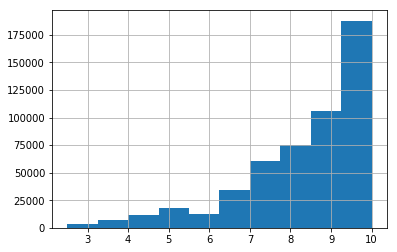

In [0]:
hotels['Reviewer_Score'].hist()

In [0]:
def fit_and_infer(X_train,y_train,X_test,y_test,num_round=500,linear=True):
  xgb_train = xgb.DMatrix(X_train,label=y_train)
  xgb_x_test = xgb.DMatrix(X_test,label=y_test)
  
  if linear==True:
    xgb_params = {
        'verbosity' : 0,
        'objective': 'reg:gamma',
        'nthread': 5,
        'max_depth':5
    }
  else:
    xgb_params = {
        #'verbosity' : 0,
        #'max_depth': 5,
        'objective': 'multi:softprob',
        'num_class': 9,
        'nthread':5
    }
    num_round=50
  
  watchlist = [(xgb_train, 'train'), (xgb_x_test, 'test')]
  
  clf = xgb.train(xgb_params, xgb_train, num_round, watchlist,verbose_eval=20)
  y_pred = clf.predict(xgb_x_test)
  if linear == True:
    print("r2 :",r2_score(y_test,y_pred))
    print("mse :",mean_squared_error(y_test,y_pred))
  #else:
    #print("accuracy :",accuracy_score(y_test,y_pred))
  
    plt.figure(figsize=(10,6))
    plt.scatter(y_test,y_pred);
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r',lw=4);
  return y_pred

**XGB + Linear + All TFID only**

[0]	train-gamma-nloglik:12.2502	test-gamma-nloglik:12.2554
[20]	train-gamma-nloglik:3.11831	test-gamma-nloglik:3.11882
[40]	train-gamma-nloglik:3.11668	test-gamma-nloglik:3.11734
[60]	train-gamma-nloglik:3.1161	test-gamma-nloglik:3.11691
[80]	train-gamma-nloglik:3.11572	test-gamma-nloglik:3.11665
[100]	train-gamma-nloglik:3.11543	test-gamma-nloglik:3.11646
[120]	train-gamma-nloglik:3.11521	test-gamma-nloglik:3.11634
[140]	train-gamma-nloglik:3.11501	test-gamma-nloglik:3.11625
[160]	train-gamma-nloglik:3.11484	test-gamma-nloglik:3.11616
[180]	train-gamma-nloglik:3.11469	test-gamma-nloglik:3.11609
[200]	train-gamma-nloglik:3.11456	test-gamma-nloglik:3.11603
[220]	train-gamma-nloglik:3.11442	test-gamma-nloglik:3.11598
[240]	train-gamma-nloglik:3.11431	test-gamma-nloglik:3.11595
[260]	train-gamma-nloglik:3.11421	test-gamma-nloglik:3.11593
[280]	train-gamma-nloglik:3.11411	test-gamma-nloglik:3.1159
[300]	train-gamma-nloglik:3.11402	test-gamma-nloglik:3.11588
[320]	train-gamma-nloglik:3.1139

array([8.303129 , 8.500444 , 8.375351 , ..., 5.0324297, 6.014852 ,
       8.490679 ], dtype=float32)

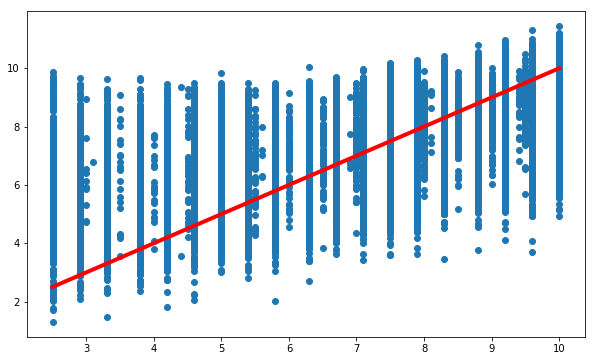

In [0]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    tfid_total_reorg, hotels['Reviewer_Score'],random_state=27)

sc = StandardScaler(with_mean=False)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

**TFID + RandomForestRegressor**

In [0]:
def fit_and_predict_random(X_train,Y_train,X_test,Y_test):
  random_model = RandomForestRegressor(n_estimators=25,max_depth=5,n_jobs=5)
  random_model.fit(X_train,Y_train)

  y_pred = random_model.predict(X_test)

  print("r2 :",r2_score(Y_test,y_pred))
  print("mse :",mean_squared_error(Y_test,y_pred))
  
  plt.figure(figsize=(10,6))
  plt.scatter(Y_test,y_pred);
  plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='r',lw=4);
  return y_pred

In [0]:
from sklearn.ensemble import RandomForestRegressor

fit_and_predict_random(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test)

r2 : 0.3137711228056259
mse : 1.8432413876913212


**TFID+Ridge**

r2 : 0.3137711228056259
mse : 1.8432413876913212


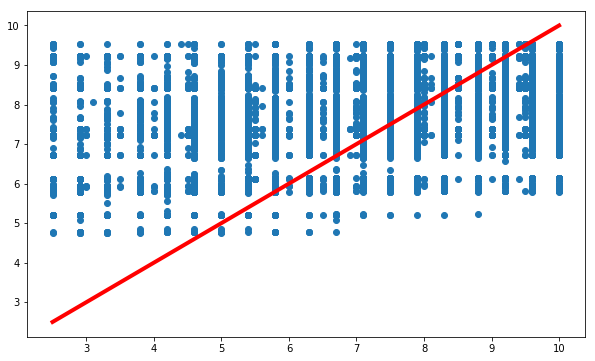

In [0]:
ridge_model = Ridge(alpha=100, solver='sag')#,n_jobs=5)
ridge_model.fit(sparse_X_train,sparse_Y_train)

y_pred = random_model.predict(sparse_X_test)

print("r2 :",r2_score(sparse_Y_test,y_pred))
print("mse :",mean_squared_error(sparse_Y_test,y_pred))
  
plt.figure(figsize=(10,6))
plt.scatter(sparse_Y_test,y_pred);
plt.plot([sparse_Y_test.min(), sparse_Y_test.max()], [sparse_Y_test.min(), sparse_Y_test.max()], c='r',lw=4);


**Hotel features with TFID values**

There are other features in the hotel data that could be used along with TFID values for prediction. Looking at r2 values of above predictions, it looks like using entire set of TFID values will give a better prediction than restricted set (of 25 top values). 

In order to do the same, hotel data has to be cleaned. 

- Some of the string values are already converted to numeric
- Lattitude and Longitide can be removed (assumption that this may not make a lot of difference)
- Positive_review and Negative_Review can be removed since TFID values will be introduced
- Hotel Address can be dropped since Country attribute is retained
- Tags are removed now (Maybe used later depending on value derived from Tags)

In [0]:
hotels.corr()

,Additional_Number_of_Scoring,Review_Date,Average_Score,Reviewer_Nationality,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,days_since_review,lat,lng,Country,Trip,Group_Type,Mobile,Stayed
Additional_Number_of_Scoring,1.000000,-0.011213,-0.152846,-0.115590,0.029195,0.824884,-0.053087,-0.071969,-0.061554,0.011818,0.336295,-0.295732,-0.340345,-0.008892,-0.011262,0.042692,-0.111459
Review_Date,-0.011213,1.000000,-0.003924,0.018455,-0.009045,-0.004188,-0.020136,0.009517,-0.018506,0.134383,-0.019354,0.020894,0.025955,0.000176,-0.005281,0.001821,0.013975
Average_Score,-0.152846,-0.003924,1.000000,-0.008986,-0.112323,-0.179568,0.106719,0.036454,0.364351,-0.013993,-0.108642,0.106078,0.112283,-0.049765,-0.101733,0.004919,0.015576
Reviewer_Nationality,-0.115590,0.018455,-0.008986,1.000000,-0.020855,-0.022370,-0.040837,0.096818,-0.067594,0.001727,-0.131512,0.201489,0.193059,0.053586,0.111506,-0.030479,0.217161
Review_Total_Negative_Word_Counts,0.029195,-0.009045,-0.112323,-0.020855,1.000000,0.035124,0.119613,0.003199,-0.382474,-0.043283,0.019112,-0.020002,-0.025894,0.001773,0.003706,-0.082241,0.038596
Total_Number_of_Reviews,0.824884,-0.004188,-0.179568,-0.022370,0.035124,1.000000,-0.030132,-0.024910,-0.072865,0.007157,0.100295,-0.014141,-0.095808,-0.014080,0.003125,0.016524,-0.035895
Review_Total_Positive_Word_Counts,-0.053087,-0.020136,0.106719,-0.040837,0.119613,-0.030132,1.000000,0.026535,0.220800,-0.044936,-0.037567,0.035471,0.026347,-0.059753,-0.042533,-0.108094,0.055918
Total_Number_of_Reviews_Reviewer_Has_Given,-0.071969,0.009517,0.036454,0.096818,0.003199,-0.024910,0.026535,1.000000,0.002873,0.035025,-0.059793,0.110810,0.106833,0.120420,0.079563,-0.130055,-0.008485
Reviewer_Score,-0.061554,-0.018506,0.364351,-0.067594,-0.382474,-0.072865,0.220800,0.002873,1.000000,0.002610,-0.036562,0.034001,0.029534,-0.088655,-0.079759,0.014054,-0.013794
days_since_review,0.011818,0.134383,-0.013993,0.001727,-0.043283,0.007157,-0.044936,0.035025,0.002610,1.000000,-0.000185,-0.000991,0.009688,0.014282,-0.054821,-0.037530,0.001940


[0]	train-gamma-nloglik:12.2502	test-gamma-nloglik:12.2554
[20]	train-gamma-nloglik:3.1172	test-gamma-nloglik:3.11775
[40]	train-gamma-nloglik:3.11575	test-gamma-nloglik:3.1165
[60]	train-gamma-nloglik:3.11523	test-gamma-nloglik:3.11614
[80]	train-gamma-nloglik:3.11488	test-gamma-nloglik:3.11593
[100]	train-gamma-nloglik:3.11462	test-gamma-nloglik:3.11579
[120]	train-gamma-nloglik:3.11437	test-gamma-nloglik:3.11565
[140]	train-gamma-nloglik:3.11419	test-gamma-nloglik:3.11558
[160]	train-gamma-nloglik:3.11403	test-gamma-nloglik:3.11551
[180]	train-gamma-nloglik:3.11389	test-gamma-nloglik:3.11545
[200]	train-gamma-nloglik:3.11374	test-gamma-nloglik:3.11539
[220]	train-gamma-nloglik:3.11363	test-gamma-nloglik:3.11536
[240]	train-gamma-nloglik:3.11353	test-gamma-nloglik:3.11532
[260]	train-gamma-nloglik:3.11343	test-gamma-nloglik:3.11529
[280]	train-gamma-nloglik:3.11333	test-gamma-nloglik:3.11526
[300]	train-gamma-nloglik:3.11323	test-gamma-nloglik:3.11524
[320]	train-gamma-nloglik:3.1131

array([8.453303 , 8.757149 , 8.827854 , ..., 5.5284615, 6.7697277,
       8.441477 ], dtype=float32)

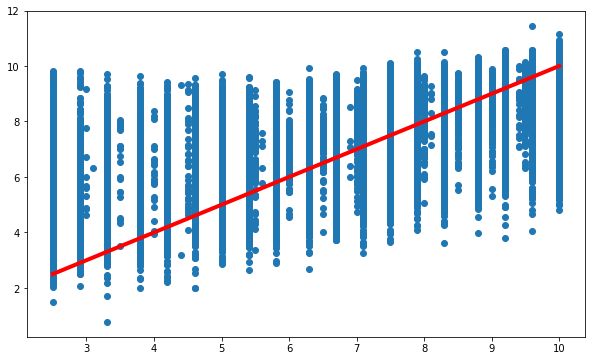

In [0]:
hotels_edited = hotels.drop(
    ['Hotel_Address','Reviewer_Score','Additional_Number_of_Scoring',
     'Hotel_Name','Negative_Review','Positive_Review','Tags','lat',
     'Total_Number_of_Reviews','Review_Date',
     'Review_Total_Negative_Word_Counts','Trip','Group_Type', 'Stayed'],axis=1)
hotels_sparse = hstack(
    (csr_matrix(hotels_edited.loc[np.arange(0,hotels_edited.shape[0]),:].values), 
     tfid_total_reorg))
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    hotels_sparse, hotels['Reviewer_Score'],random_state=27)
sc = StandardScaler(with_mean=False)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

**TFID+Prob+XGB**

[0]	train-gamma-nloglik:12.2502	test-gamma-nloglik:12.2554
[20]	train-gamma-nloglik:3.11751	test-gamma-nloglik:3.11802
[40]	train-gamma-nloglik:3.11603	test-gamma-nloglik:3.11671
[60]	train-gamma-nloglik:3.11553	test-gamma-nloglik:3.11635
[80]	train-gamma-nloglik:3.11522	test-gamma-nloglik:3.11617
[100]	train-gamma-nloglik:3.11495	test-gamma-nloglik:3.11602
[120]	train-gamma-nloglik:3.11475	test-gamma-nloglik:3.11592
[140]	train-gamma-nloglik:3.11457	test-gamma-nloglik:3.11584
[160]	train-gamma-nloglik:3.11441	test-gamma-nloglik:3.11576
[180]	train-gamma-nloglik:3.1143	test-gamma-nloglik:3.11571
[200]	train-gamma-nloglik:3.11417	test-gamma-nloglik:3.11567
[220]	train-gamma-nloglik:3.11403	test-gamma-nloglik:3.11561
[240]	train-gamma-nloglik:3.11393	test-gamma-nloglik:3.11558
[260]	train-gamma-nloglik:3.11384	test-gamma-nloglik:3.11555
[280]	train-gamma-nloglik:3.11374	test-gamma-nloglik:3.11552
[300]	train-gamma-nloglik:3.11366	test-gamma-nloglik:3.11551
[320]	train-gamma-nloglik:3.113

array([8.142124 , 8.308574 , 8.450861 , ..., 5.8593245, 6.1272078,
       8.378238 ], dtype=float32)

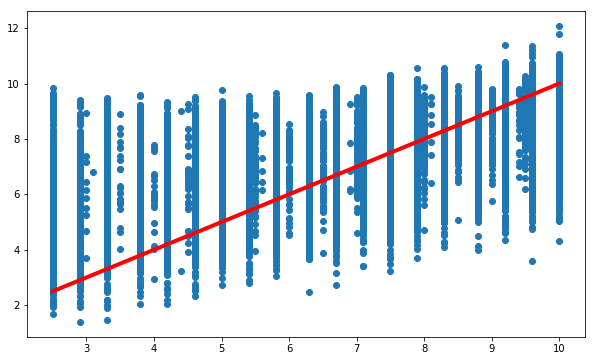

In [0]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    tfid_prob_reorg, hotels['Reviewer_Score'],random_state=27)

sc = StandardScaler(with_mean=False)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

**TFID+Prob+RandomForestRegressor**

r2 : 0.3332001309551921
mse : 1.7910542047655749


array([8.41748429, 8.41748429, 8.41748429, ..., 6.72995675, 6.27922078,
       8.41748429])

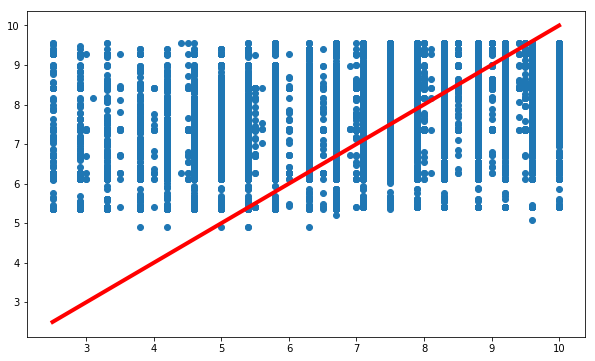

In [0]:
fit_and_predict_random(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test)

**Hotels+TFID+Prob+XGB**

[0]	train-gamma-nloglik:12.2501	test-gamma-nloglik:12.2554
[20]	train-gamma-nloglik:3.11646	test-gamma-nloglik:3.117
[40]	train-gamma-nloglik:3.1151	test-gamma-nloglik:3.11583
[60]	train-gamma-nloglik:3.11465	test-gamma-nloglik:3.11551
[80]	train-gamma-nloglik:3.11434	test-gamma-nloglik:3.11534
[100]	train-gamma-nloglik:3.11413	test-gamma-nloglik:3.11525
[120]	train-gamma-nloglik:3.11393	test-gamma-nloglik:3.11517
[140]	train-gamma-nloglik:3.11376	test-gamma-nloglik:3.11508
[160]	train-gamma-nloglik:3.11363	test-gamma-nloglik:3.11504
[180]	train-gamma-nloglik:3.11351	test-gamma-nloglik:3.115
[200]	train-gamma-nloglik:3.11336	test-gamma-nloglik:3.11495
[220]	train-gamma-nloglik:3.11326	test-gamma-nloglik:3.11493
[240]	train-gamma-nloglik:3.11315	test-gamma-nloglik:3.1149
[260]	train-gamma-nloglik:3.11307	test-gamma-nloglik:3.11487
[280]	train-gamma-nloglik:3.113	test-gamma-nloglik:3.11485
[300]	train-gamma-nloglik:3.11293	test-gamma-nloglik:3.11484
[320]	train-gamma-nloglik:3.11284	test

array([8.100106 , 8.76283  , 8.842239 , ..., 6.257758 , 6.6484284,
       8.267558 ], dtype=float32)

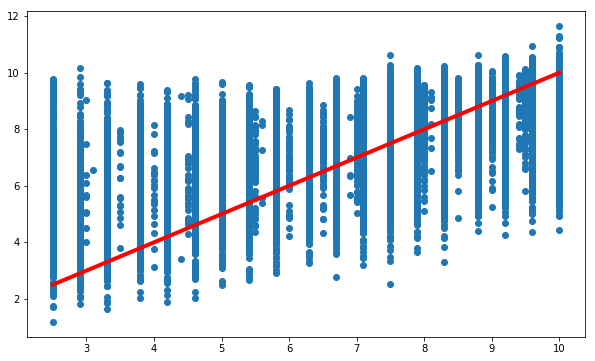

In [0]:

hotels_sparse = hstack(
    (csr_matrix(hotels_edited.loc[np.arange(0,hotels_edited.shape[0]),:].values), 
     tfid_prob_reorg))
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    hotels_sparse, hotels['Reviewer_Score'],random_state=27)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

**Top 10% TFID+XGB**

In [0]:
def get_most_freq(X,vector,n):
  avg_features = X.mean(axis=0)
  words_list = ((word, avg_features[0, i], i) for word, i in vector.vocabulary_.items())

  return sorted(words_list, key = lambda x: x[1], reverse=True)[:n]

In [0]:
top_freq_words = get_most_freq(tfid_total,count_vectorizer,round(tfid_total.shape[1]/10))
ar_top_freq_words = np.array(top_freq_words,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
tfid_top10per = tfid_total[:,ar_top_freq_words['i']]


In [0]:
#tfid_top10per_reorg = hstack([tfid_top10per[0:pos_reviews.shape[0]],tfid_top10per[pos_reviews.shape[0]:]])
#tfid_top10per_prob_reorg = hstack([tfid_top10per_reorg,csr_matrix(y_pred_reorg)])

[0]	train-gamma-nloglik:12.2502	test-gamma-nloglik:12.2554
[20]	train-gamma-nloglik:3.11832	test-gamma-nloglik:3.11883
[40]	train-gamma-nloglik:3.11669	test-gamma-nloglik:3.11738
[60]	train-gamma-nloglik:3.11611	test-gamma-nloglik:3.11694
[80]	train-gamma-nloglik:3.11573	test-gamma-nloglik:3.1167
[100]	train-gamma-nloglik:3.11544	test-gamma-nloglik:3.11652
[120]	train-gamma-nloglik:3.11522	test-gamma-nloglik:3.1164
[140]	train-gamma-nloglik:3.11502	test-gamma-nloglik:3.11629
[160]	train-gamma-nloglik:3.11485	test-gamma-nloglik:3.11621
[180]	train-gamma-nloglik:3.11469	test-gamma-nloglik:3.11614
[200]	train-gamma-nloglik:3.11456	test-gamma-nloglik:3.11609
[220]	train-gamma-nloglik:3.11443	test-gamma-nloglik:3.11604
[240]	train-gamma-nloglik:3.11431	test-gamma-nloglik:3.11599
[260]	train-gamma-nloglik:3.11419	test-gamma-nloglik:3.11597
[280]	train-gamma-nloglik:3.11409	test-gamma-nloglik:3.11594
[300]	train-gamma-nloglik:3.114	test-gamma-nloglik:3.11593
[320]	train-gamma-nloglik:3.11392	

array([8.391449 , 8.546624 , 8.396656 , ..., 6.0317965, 6.020305 ,
       8.487434 ], dtype=float32)

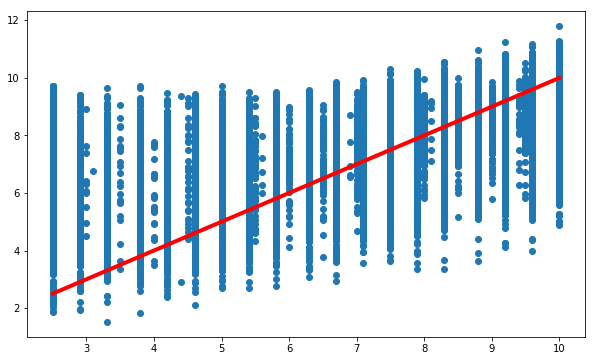

In [0]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    tfid_top10per_reorg, hotels['Reviewer_Score'],random_state=27)

sc = StandardScaler(with_mean=False)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

**Hotels +No TFID + Prob + XGB**

[0]	train-gamma-nloglik:12.2502	test-gamma-nloglik:12.2555
[20]	train-gamma-nloglik:3.11838	test-gamma-nloglik:3.11891
[40]	train-gamma-nloglik:3.11776	test-gamma-nloglik:3.11839
[60]	train-gamma-nloglik:3.11759	test-gamma-nloglik:3.11832
[80]	train-gamma-nloglik:3.11744	test-gamma-nloglik:3.11826
[100]	train-gamma-nloglik:3.11731	test-gamma-nloglik:3.11823
[120]	train-gamma-nloglik:3.1172	test-gamma-nloglik:3.11821
[140]	train-gamma-nloglik:3.11711	test-gamma-nloglik:3.11819
[160]	train-gamma-nloglik:3.11702	test-gamma-nloglik:3.11819
[180]	train-gamma-nloglik:3.11695	test-gamma-nloglik:3.11818
[200]	train-gamma-nloglik:3.11688	test-gamma-nloglik:3.11819
[220]	train-gamma-nloglik:3.1168	test-gamma-nloglik:3.11818
[240]	train-gamma-nloglik:3.11673	test-gamma-nloglik:3.11817
[260]	train-gamma-nloglik:3.11665	test-gamma-nloglik:3.11817
[280]	train-gamma-nloglik:3.11658	test-gamma-nloglik:3.11817
[300]	train-gamma-nloglik:3.1165	test-gamma-nloglik:3.11816
[320]	train-gamma-nloglik:3.11645

array([6.865105, 8.228789, 8.55671 , ..., 7.093571, 5.953309, 8.123423],
      dtype=float32)

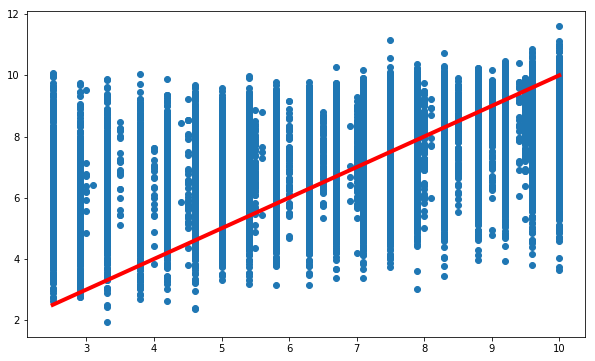

In [0]:
hotels_edited_prob = pd.concat([hotels_edited,y_pred_reorg],axis=1)
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    hotels_edited_prob, hotels['Reviewer_Score'],random_state=27)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

**Vectorizing Pos and Neg separately**

**Pos TFID+Neg TFID+XGB**

In [0]:
count_neg = count_vectorizer.fit_transform(hotels['Negative_Review'])
tfid_neg = tfid_transformer.fit_transform(count_neg)
neg_freq_words = get_most_freq(tfid_neg,count_vectorizer,25)
ar_neg_freq_words = np.array(neg_freq_words,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
words_sparse_neg = tfid_neg[:,ar_neg_freq_words['i']]

neg_freq_words

[('negative', 0.24883278494430394, 27353),
 ('room', 0.04868465206699449, 35439),
 ('small', 0.025015441482751623, 38162),
 ('breakfast', 0.022799255091495545, 5215),
 ('hotel', 0.019181686805528318, 20078),
 ('bed', 0.014048030652092409, 3915),
 ('bit', 0.013186478573087981, 4458),
 ('staff', 0.01243113771868757, 39367),
 ('bathroom', 0.011315172936861382, 3708),
 ('little', 0.011042918935778152, 24130),
 ('good', 0.010622840605124962, 18269),
 ('expensive', 0.010583292357864472, 15281),
 ('didn', 0.009509868918778714, 11750),
 ('price', 0.009364710582918588, 31906),
 ('like', 0.009060294552430282, 23945),
 ('night', 0.008813475423956793, 27664),
 ('bar', 0.008553761003045288, 3499),
 ('shower', 0.008412121051594456, 37394),
 ('service', 0.008232427907892392, 36903),
 ('really', 0.007625055995460576, 33207),
 ('poor', 0.007566113382764827, 31298),
 ('wifi', 0.0073999867283278346, 46660),
 ('time', 0.007278626734404264, 42120),
 ('noisy', 0.007236455519436842, 27890),
 ('did', 0.006510

In [0]:
count_pos = count_vectorizer.fit_transform(hotels['Positive_Review'])
tfid_pos = tfid_transformer.fit_transform(count_pos)
pos_freq_words = get_most_freq(tfid_pos,count_vectorizer,25)
ar_pos_freq_words = np.array(pos_freq_words,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
words_sparse_pos = tfid_pos[:,ar_pos_freq_words['i']]

pos_freq_words

[('location', 0.09557816590911236, 23804),
 ('positive', 0.06994401955910716, 31044),
 ('staff', 0.06616354484909034, 38144),
 ('room', 0.0521312081467436, 34586),
 ('good', 0.04848259684489779, 17890),
 ('great', 0.04514820734767536, 18178),
 ('friendly', 0.03938219712454458, 16791),
 ('hotel', 0.03790215972671206, 19781),
 ('breakfast', 0.03754259556259372, 5415),
 ('helpful', 0.033229020569550925, 19164),
 ('clean', 0.03173283318257884, 7889),
 ('excellent', 0.03163588563345358, 14591),
 ('nice', 0.030996763879667252, 27576),
 ('bed', 0.030375685246488468, 4139),
 ('comfortable', 0.028406095177209382, 8523),
 ('lovely', 0.01733109439982136, 24164),
 ('perfect', 0.015169622693446993, 29962),
 ('service', 0.014876023087463188, 36016),
 ('comfy', 0.014152746414941492, 8589),
 ('close', 0.013416719352954081, 8097),
 ('really', 0.012860645691247405, 32692),
 ('station', 0.012427794619793582, 38365),
 ('stay', 0.012146936597736866, 38411),
 ('amazing', 0.012024496361418356, 1484),
 ('view

[0]	train-gamma-nloglik:12.2502	test-gamma-nloglik:12.2554
[20]	train-gamma-nloglik:3.11831	test-gamma-nloglik:3.11883
[40]	train-gamma-nloglik:3.11668	test-gamma-nloglik:3.11736
[60]	train-gamma-nloglik:3.11611	test-gamma-nloglik:3.11694
[80]	train-gamma-nloglik:3.11573	test-gamma-nloglik:3.11668
[100]	train-gamma-nloglik:3.11542	test-gamma-nloglik:3.1165
[120]	train-gamma-nloglik:3.11521	test-gamma-nloglik:3.11637
[140]	train-gamma-nloglik:3.11502	test-gamma-nloglik:3.11628
[160]	train-gamma-nloglik:3.11484	test-gamma-nloglik:3.11619
[180]	train-gamma-nloglik:3.11469	test-gamma-nloglik:3.11613
[200]	train-gamma-nloglik:3.11455	test-gamma-nloglik:3.11606
[220]	train-gamma-nloglik:3.11443	test-gamma-nloglik:3.11602
[240]	train-gamma-nloglik:3.11432	test-gamma-nloglik:3.11598
[260]	train-gamma-nloglik:3.11422	test-gamma-nloglik:3.11595
[280]	train-gamma-nloglik:3.11412	test-gamma-nloglik:3.11592
[300]	train-gamma-nloglik:3.11403	test-gamma-nloglik:3.11589
[320]	train-gamma-nloglik:3.113

array([8.5083685, 8.501634 , 8.410421 , ..., 5.40501  , 6.0935483,
       8.50151  ], dtype=float32)

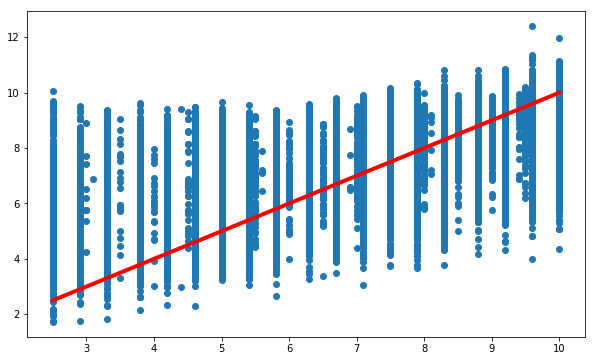

In [0]:
tfid_pos_neg = hstack([tfid_pos,tfid_neg])
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    tfid_pos_neg, hotels['Reviewer_Score'],random_state=27)

sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

**Hotel+ TFID Pos Neg + XGB**

[0]	train-gamma-nloglik:12.2502	test-gamma-nloglik:12.2554
[20]	train-gamma-nloglik:3.11722	test-gamma-nloglik:3.11772
[40]	train-gamma-nloglik:3.11575	test-gamma-nloglik:3.11645
[60]	train-gamma-nloglik:3.11522	test-gamma-nloglik:3.11608
[80]	train-gamma-nloglik:3.11486	test-gamma-nloglik:3.11588
[100]	train-gamma-nloglik:3.1146	test-gamma-nloglik:3.11574
[120]	train-gamma-nloglik:3.11437	test-gamma-nloglik:3.11561
[140]	train-gamma-nloglik:3.11416	test-gamma-nloglik:3.11551
[160]	train-gamma-nloglik:3.11399	test-gamma-nloglik:3.11544
[180]	train-gamma-nloglik:3.11384	test-gamma-nloglik:3.11538
[200]	train-gamma-nloglik:3.11371	test-gamma-nloglik:3.11534
[220]	train-gamma-nloglik:3.1136	test-gamma-nloglik:3.11531
[240]	train-gamma-nloglik:3.1135	test-gamma-nloglik:3.11527
[260]	train-gamma-nloglik:3.1134	test-gamma-nloglik:3.11525
[280]	train-gamma-nloglik:3.11329	test-gamma-nloglik:3.11523
[300]	train-gamma-nloglik:3.11319	test-gamma-nloglik:3.1152
[320]	train-gamma-nloglik:3.11311	t

array([8.445732 , 8.675291 , 8.966298 , ..., 6.271479 , 6.3343654,
       8.336601 ], dtype=float32)

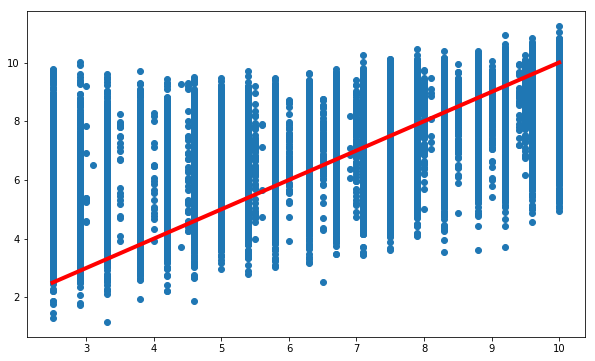

In [0]:
hotel_tfid_pos_neg = hstack([csr_matrix(hotels_edited),tfid_pos_neg])
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    hotel_tfid_pos_neg, hotels['Reviewer_Score'],random_state=27)

sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

**Xboost Classification TFID Pos Neg**

In [0]:
hotels['Reviewer_Score_class'] = (round(hotels['Reviewer_Score'])-2).astype(int)
#round(hotels['Reviewer_Score']*2)/2

hotels['Reviewer_Score_class'].unique()

array([1, 6, 5, 2, 3, 8, 4, 7, 0])

In [0]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    tfid_pos_neg, hotels['Reviewer_Score_class'],random_state=27)

sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

xgb_train = xgb.DMatrix(sparse_X_train,label = sparse_Y_train)
xgb_x_test = xgb.DMatrix(sparse_X_test)
  
xgb_params = {
        #'verbosity' : 0,
        #'max_depth': 5,
        'objective': 'multi:softmax',
        'num_class': 9,
        'nthread':5
}
num_round=50
  
watchlist = [(xgb_train, 'train')]
  
clf = xgb.train(xgb_params, xgb_train, num_round, watchlist,verbose_eval=20)
y_pred = clf.predict(xgb_x_test)

[0]	train-merror:0.577837
[20]	train-merror:0.539773
[40]	train-merror:0.518683
[49]	train-merror:0.512341


In [0]:
y_pred
print("accuracy :",accuracy_score(sparse_Y_test,y_pred))

accuracy : 0.4531585682708341


**Hotel+XBoost Classification +TFID Pos Neg**

In [0]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    hotel_tfid_pos_neg, hotels['Reviewer_Score_class'],random_state=27)

sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

xgb_train = xgb.DMatrix(sparse_X_train,label = sparse_Y_train)
xgb_x_test = xgb.DMatrix(sparse_X_test)
  
xgb_params = {
        #'verbosity' : 0,
        #'max_depth': 5,
        'objective': 'multi:softmax',
        'num_class': 9,
        'nthread':5
}
num_round=50
  
watchlist = [(xgb_train, 'train')]
  
clf = xgb.train(xgb_params, xgb_train, num_round, watchlist,verbose_eval=20)
y_pred = clf.predict(xgb_x_test)

[0]	train-merror:0.57226
[20]	train-merror:0.526369
[40]	train-merror:0.504588
[49]	train-merror:0.497514


In [0]:
print("accuracy :",accuracy_score(sparse_Y_test,y_pred))

accuracy : 0.46231046651413504




---

# Frequent words
Top 25 words that influenced the training set are identified in Positive and Negative sets and plotted

A word cloud is drawn is to see top 100 words to see how different top 100 words of combined review is when compared to top 25 of Positive and Negative words, 

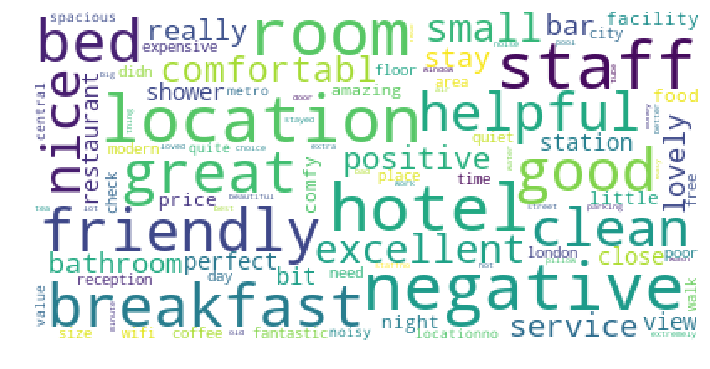

In [0]:
top_freq_words = get_most_freq(tfid_total,count_vectorizer,100)
ar_top_freq_words = np.array(top_freq_words,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])

wordcloud = WordCloud(
                          background_color='white',
                          max_words=1000,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(ar_top_freq_words['w']).replace('\'',''))

fig = plt.figure(1,figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Top 100 words")
plt.show()

In [0]:
tfid_train_pos = tfid_X_train[np.where(y_train==1)]
tfid_train_neg = tfid_X_train[np.where(y_train==0)]

pos_freq_words_train = get_most_freq(tfid_train_pos,count_vectorizer,25)
neg_freq_words_train = get_most_freq(tfid_train_neg,count_vectorizer,25)

print(pos_freq_words_train)
print(neg_freq_words_train)

[('location', 0.11304814581605685, 30407), ('staff', 0.07808754123966678, 49054), ('good', 0.055733138102264636, 22818), ('great', 0.05241352804047448, 23139), ('room', 0.0512196442665491, 44297), ('friendly', 0.04618992071582907, 21457), ('hotel', 0.040528969492907414, 25142), ('breakfast', 0.03964485581921877, 6738), ('helpful', 0.038944839391740635, 24396), ('excellent', 0.036902954910794705, 18653), ('clean', 0.03655291667383888, 9774), ('nice', 0.03590793957272434, 34952), ('comfortable', 0.03314787328807103, 10616), ('bed', 0.03275931899193396, 5131), ('lovely', 0.01997342402184526, 30807), ('perfect', 0.01702579939373183, 38195), ('comfy', 0.016171625752510146, 10679), ('service', 0.015569836933216029, 46134), ('close', 0.015174248863109788, 10050), ('station', 0.014212197059278517, 49323), ('amazing', 0.013753704167109087, 1868), ('really', 0.01372549245020065, 41717), ('stay', 0.013162451475728996, 49371), ('view', 0.012768912075234696, 56233), ('quiet', 0.012763068166000851, 

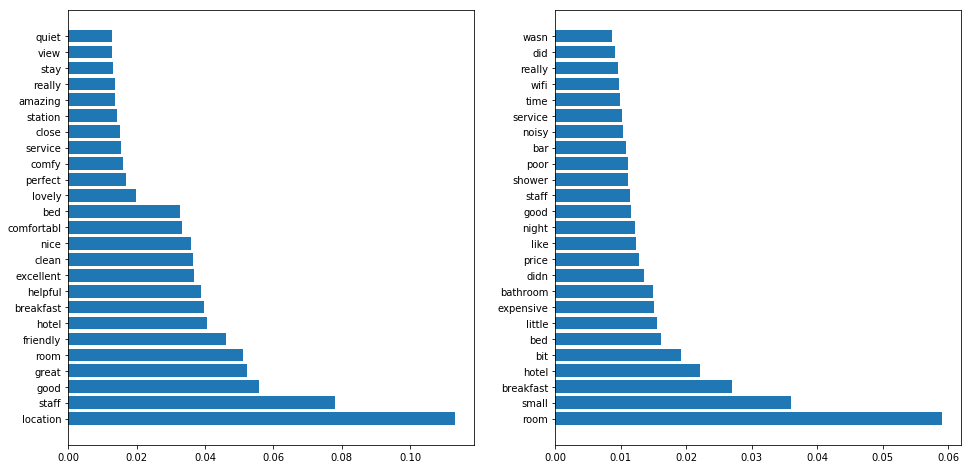

In [0]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,2,1)
ar_pos_freq_words = np.array(pos_freq_words_train,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
pos_width = ar_pos_freq_words['c']
pos_words = ar_pos_freq_words['w']
ax.barh(np.arange(25),pos_width,color='green');
ax.set_yticks(np.arange(25))
ax.set_yticklabels(pos_words);
ax.title("Top Positive Words")
ax=fig.add_subplot(1,2,2)
ar_neg_freq_words = np.array(neg_freq_words_train,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
neg_width = ar_neg_freq_words['c']
neg_words = ar_neg_freq_words['w']
ax.barh(np.arange(25),neg_width,color='red');
ax.set_yticks(np.arange(25))
ax.set_yticklabels(neg_words);
ax.title("Top Negative Words")
plt.show();

As seen above, XGB regression with hotel features as well as TFID values give an impressive output with r2 of 0.97. TODO (Can we classify the Average score into buckets of values and see how the output looks)?



---

#Data Analysis 

**Average Score vs Reviewer Nationality. Any bias?**


In [0]:
def plot_reviewer_nation_score(score_by_reviewer_nation,count,ascending=True,xlim=(8,9)): 
#  
  avg_score_by_reviewer_nation = score_by_reviewer_nation.mean()
  avg_score_by_reviewer_nation.index=reviewer_nationality_unique[
      avg_score_by_reviewer_nation.index
  ]

  asc_avg_score_by_reviewer_nation = avg_score_by_reviewer_nation.sort_values(ascending=ascending).tail(count)
  asc_avg_score_by_reviewer_nation.plot.barh(color='orange',figsize=(10,10),xlim=xlim);
  return avg_score_by_reviewer_nation

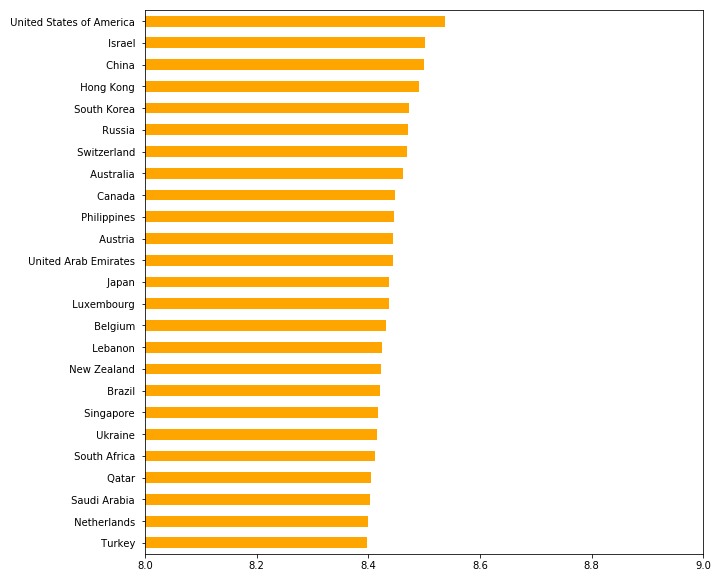

In [0]:
score_by_reviewer_nation = hotels.groupby('Reviewer_Nationality')['Reviewer_Score']
total = score_by_reviewer_nation.count()

count_index = np.where(score_by_reviewer_nation.count()>1000)
score_reviewer_gt1000 = hotels[
    hotels['Reviewer_Nationality'].isin(count_index[0])].groupby(
    'Reviewer_Nationality')['Reviewer_Score']

avg_score_by_reviewer_nation = plot_reviewer_nation_score(score_reviewer_gt1000,25)

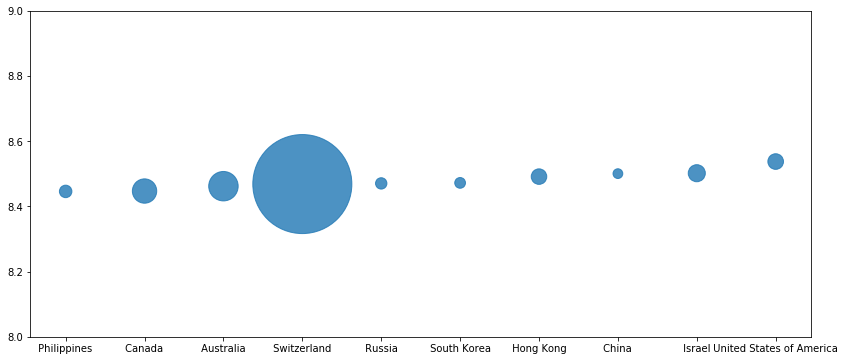

In [0]:
top_10 = avg_score_by_reviewer_nation.sort_values(ascending=True).tail(10)
plt.figure(figsize=(14,6))
plt.scatter(top_10.index, top_10,s=total/25,alpha=0.8)
plt.ylim(8,9);
plt.xticks(rotation=50)

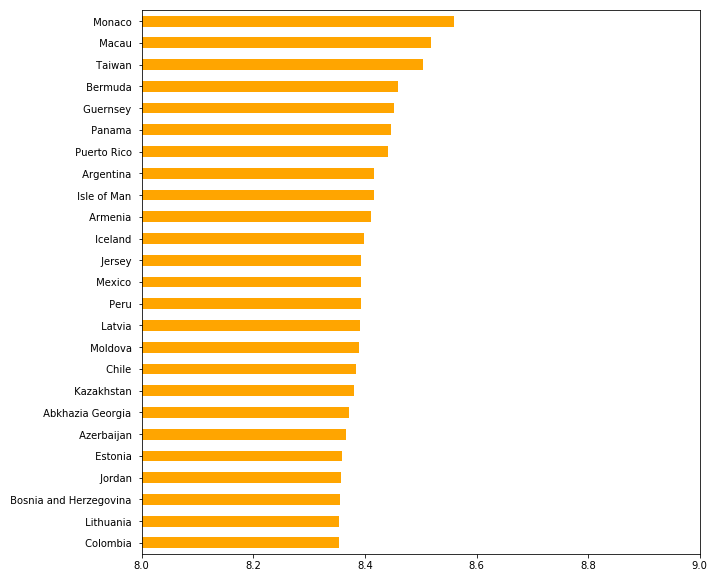

In [0]:
count_index = np.where((score_by_reviewer_nation.count()<=1000) & (score_by_reviewer_nation.count()>100))
score_reviewer_gt100 = hotels[
    hotels['Reviewer_Nationality'].isin(count_index[0])].groupby(
    'Reviewer_Nationality')['Reviewer_Score']

avg_score_by_reviewer_nation = plot_reviewer_nation_score(score_reviewer_gt100,25)

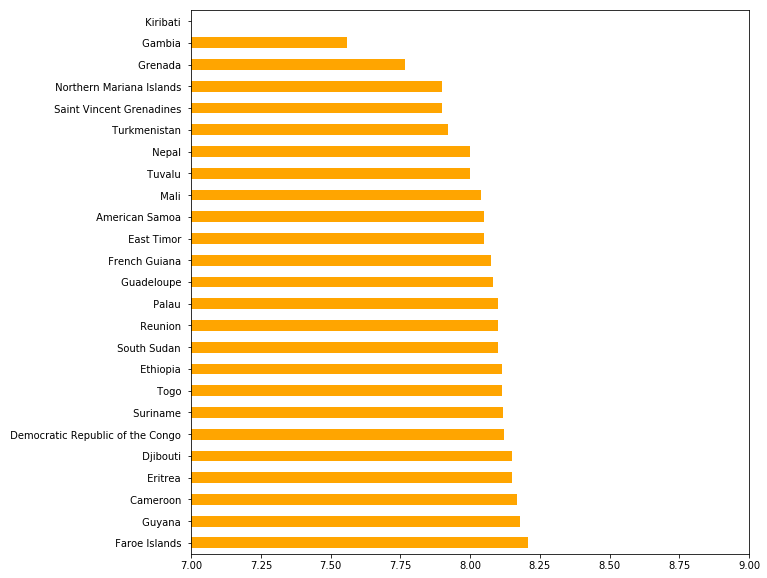

In [0]:
count_index = np.where((score_by_reviewer_nation.count()<=100))
score_reviewer_rem = hotels[
    hotels['Reviewer_Nationality'].isin(count_index[0])].groupby(
    'Reviewer_Nationality')['Reviewer_Score']

asc_avg_score_by_reviewer_nation = plot_reviewer_nation_score(score_reviewer_rem,25,False,(7,9))